# Index   

 
[Exploratory Data Analysis](#ExploratoryDataAnalysis)

[Importing libraries](##Importing-libraries)

[Reading the data set](###Reading-the-data-set)

[Model Screening](#Model-Screening)

[Tunning Random Forest Hyperparameters with Optuna](##Random-Forest-Hyperparameters-tunning-with-Optuna)

[Prediction of test_X](##test_X-prediction)



# Exploratory-Data-Analysis
<a id="A00001"></a>

### Importing libraries

In [2]:
#data exploration&manipulation
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from collections import Counter
import seaborn as sns
import matplotlib.style as style 

import datetime as dt
import os
import matplotlib.pyplot as plt

#ML Models search and optimisation
from pycaret.classification import * 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
#from sklearn.model_selection import GridSearchCV
#from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, confusion_matrix
import optuna
#from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score

#Neural Networks
import torch
import torch.nn as nn
import torch.optim as optim



%matplotlib inline

### Reading the data set

In [3]:
   
# Import space_X_train.csv
import pandas as pd
space_X_train = pd.read_csv(r'C:\Users\march\000 Treball Ju`yter 000\Hackathons\Hackathon_Talent_Squad\initial_docs\space_X_train.csv', index_col=0)

In [4]:
space_X_train.head()


,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,target
0,0.474335,0.881640,-2.050543,-1.251935,-1.035151,-1.934367,4
1,-1.034675,1.741801,-1.660629,-1.555989,-0.337553,-2.473838,0
2,-0.563221,-0.688381,-0.318415,-1.845172,0.352366,-0.912928,1
3,-1.268179,2.770688,1.054193,2.830389,0.395093,0.677715,3
4,-1.216380,-0.391267,-2.898931,-0.913074,-2.171857,-2.367490,0


In [5]:
space_X_train.isnull().sum()

sensor_1    0
sensor_2    0
sensor_3    0
sensor_4    0
sensor_5    0
sensor_6    0
target      0
dtype: int64

In [6]:
space_X_train.describe()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,target
count,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000
mean,-0.204656,0.199249,-0.378140,-0.206425,-0.186419,-0.433229,1.980476
std,1.543613,1.614024,1.450548,1.442225,1.501573,1.188791,1.410537
min,-6.683655,-5.383371,-6.147055,-5.653594,-5.912521,-4.433189,0.000000
25%,-1.171340,-0.877386,-1.365990,-1.259403,-1.211685,-1.131944,1.000000
50%,-0.443868,0.320507,-0.439745,-0.176504,-0.195751,-0.406754,2.000000
75%,0.890023,1.321430,0.662898,0.866879,0.851843,0.348593,3.000000
max,4.565547,6.700133,4.157518,4.371912,5.068783,4.016324,4.000000


Values of sensors are very similar (range from -0.433 to 6.700). There is no null values to be cleaned.

In [7]:
y = space_X_train.target

Text(0, 0.5, '# of instances')

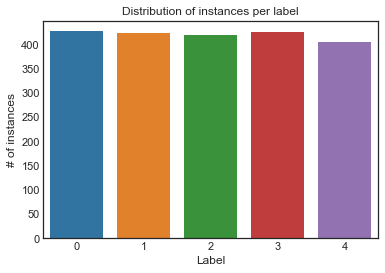

In [10]:

#Label distribution checking
sns.set_context("notebook")
style.use('seaborn-white')    
counter = Counter(y)
dist_plot=sns.barplot(x=list(counter.keys()), y=list(counter.values()))
dist_plot.set_title('Distribution of instances per label')
dist_plot.set_xlabel('Label')
dist_plot.set_ylabel('# of instances')

In [72]:
ratio_labels= [x/len(y) for x in list(counter.values())]
ratio_labels

[0.19285714285714287,
 0.20333333333333334,
 0.20142857142857143,
 0.20285714285714285,
 0.19952380952380952]

Distribution of samples are very similiar each other, there is no minoritay/majotary class in the label column.

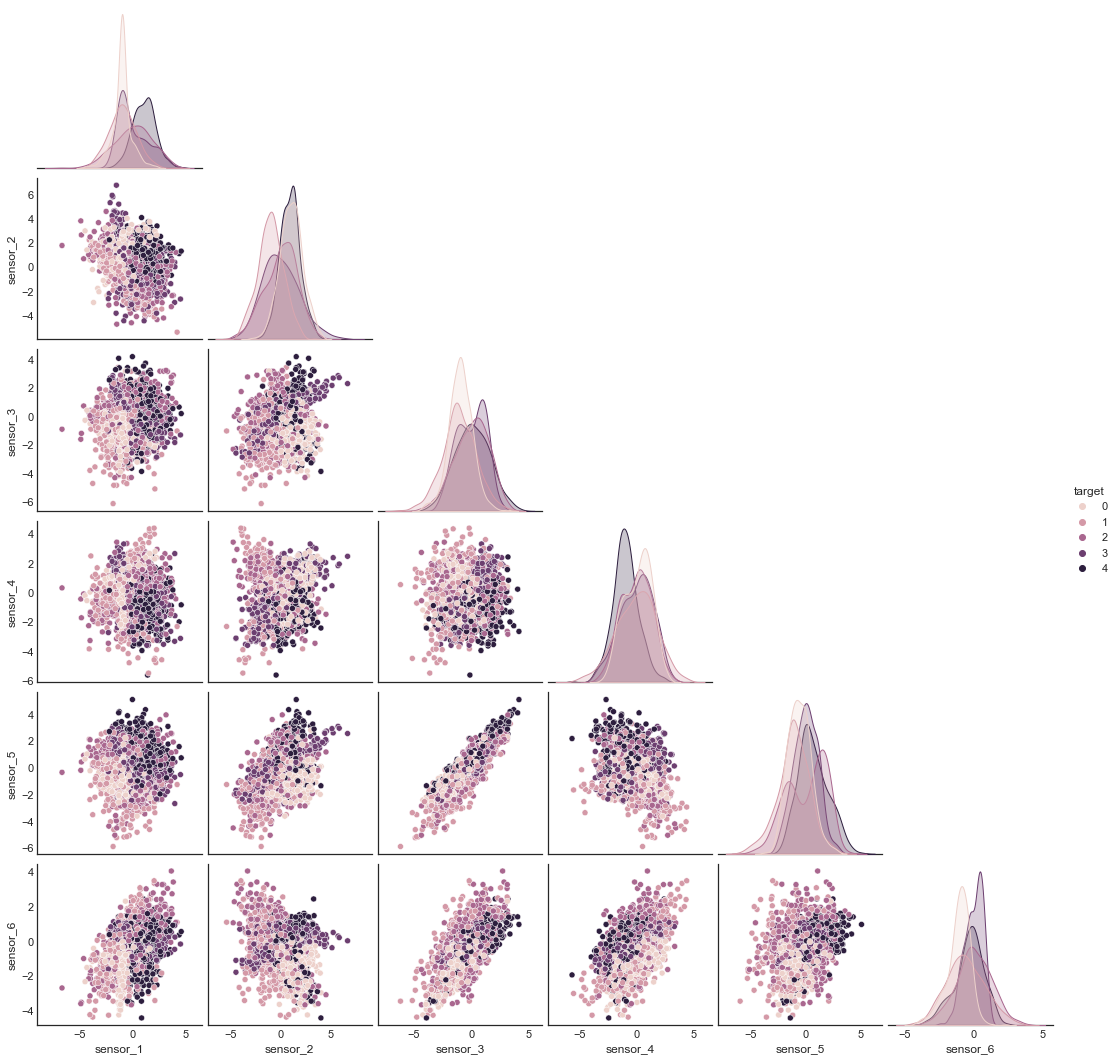

In [11]:
sns.pairplot(space_X_train, corner=True,hue='target')

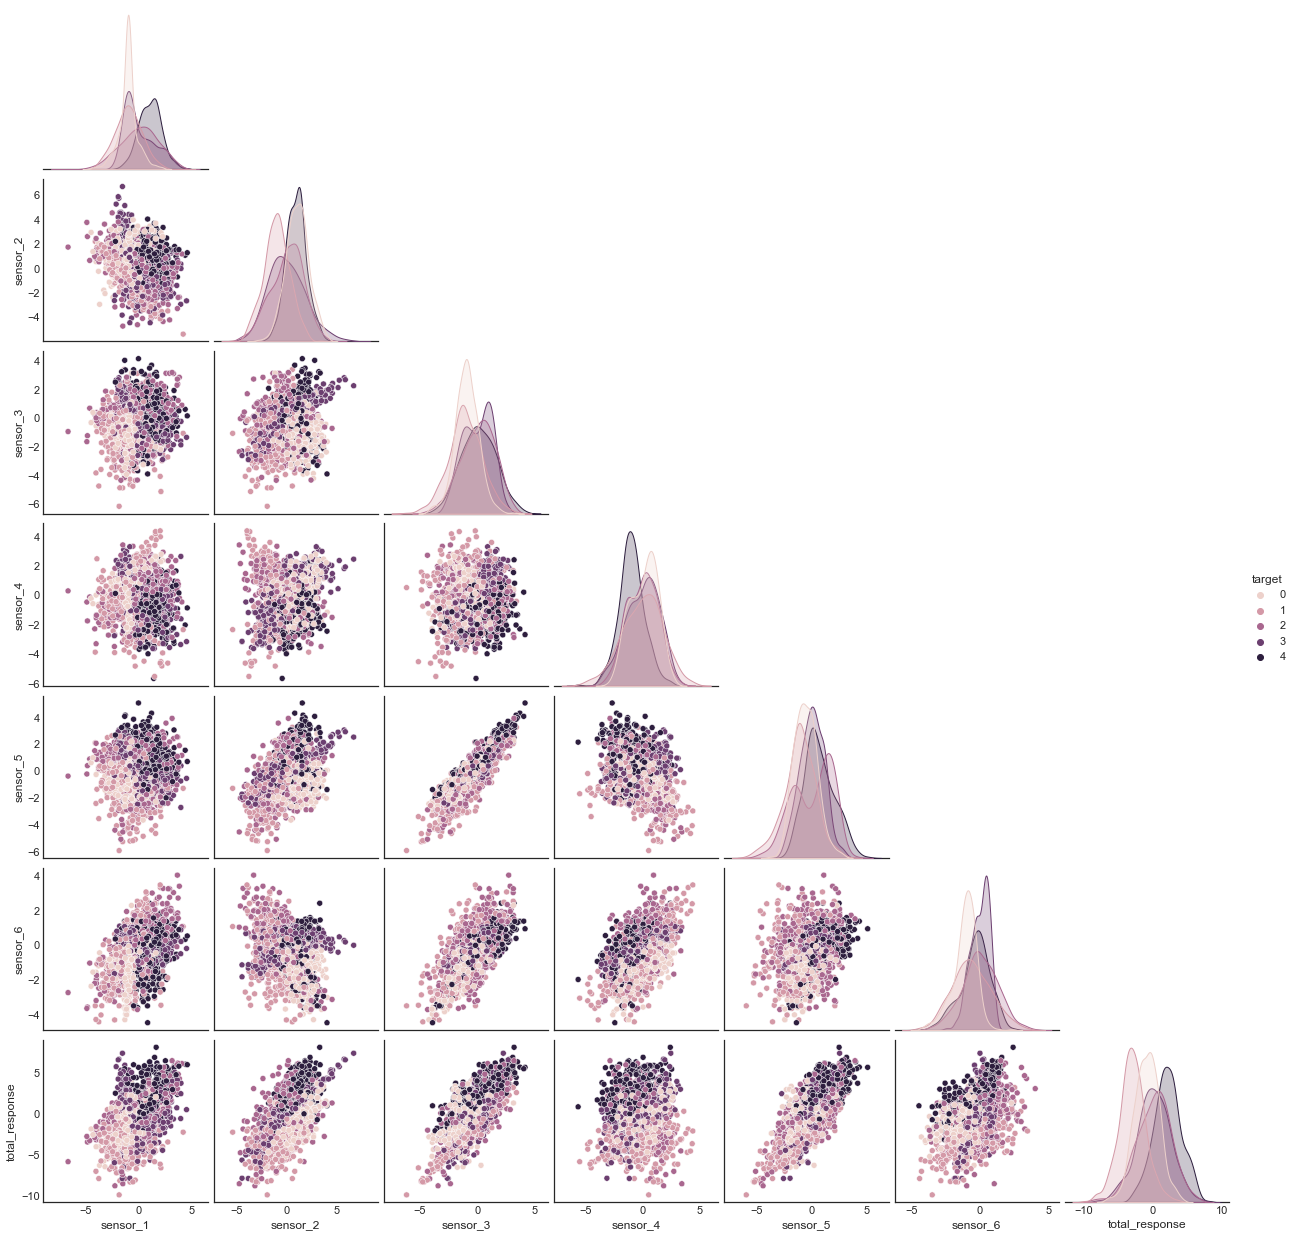

In [12]:
space_X_train_extra2= space_X_train.copy()
space_X_train_extra2['total_response']=space_X_train['sensor_1']+space_X_train['sensor_2']+space_X_train['sensor_3']
sns.pairplot(space_X_train_extra2, corner=True, hue='target')

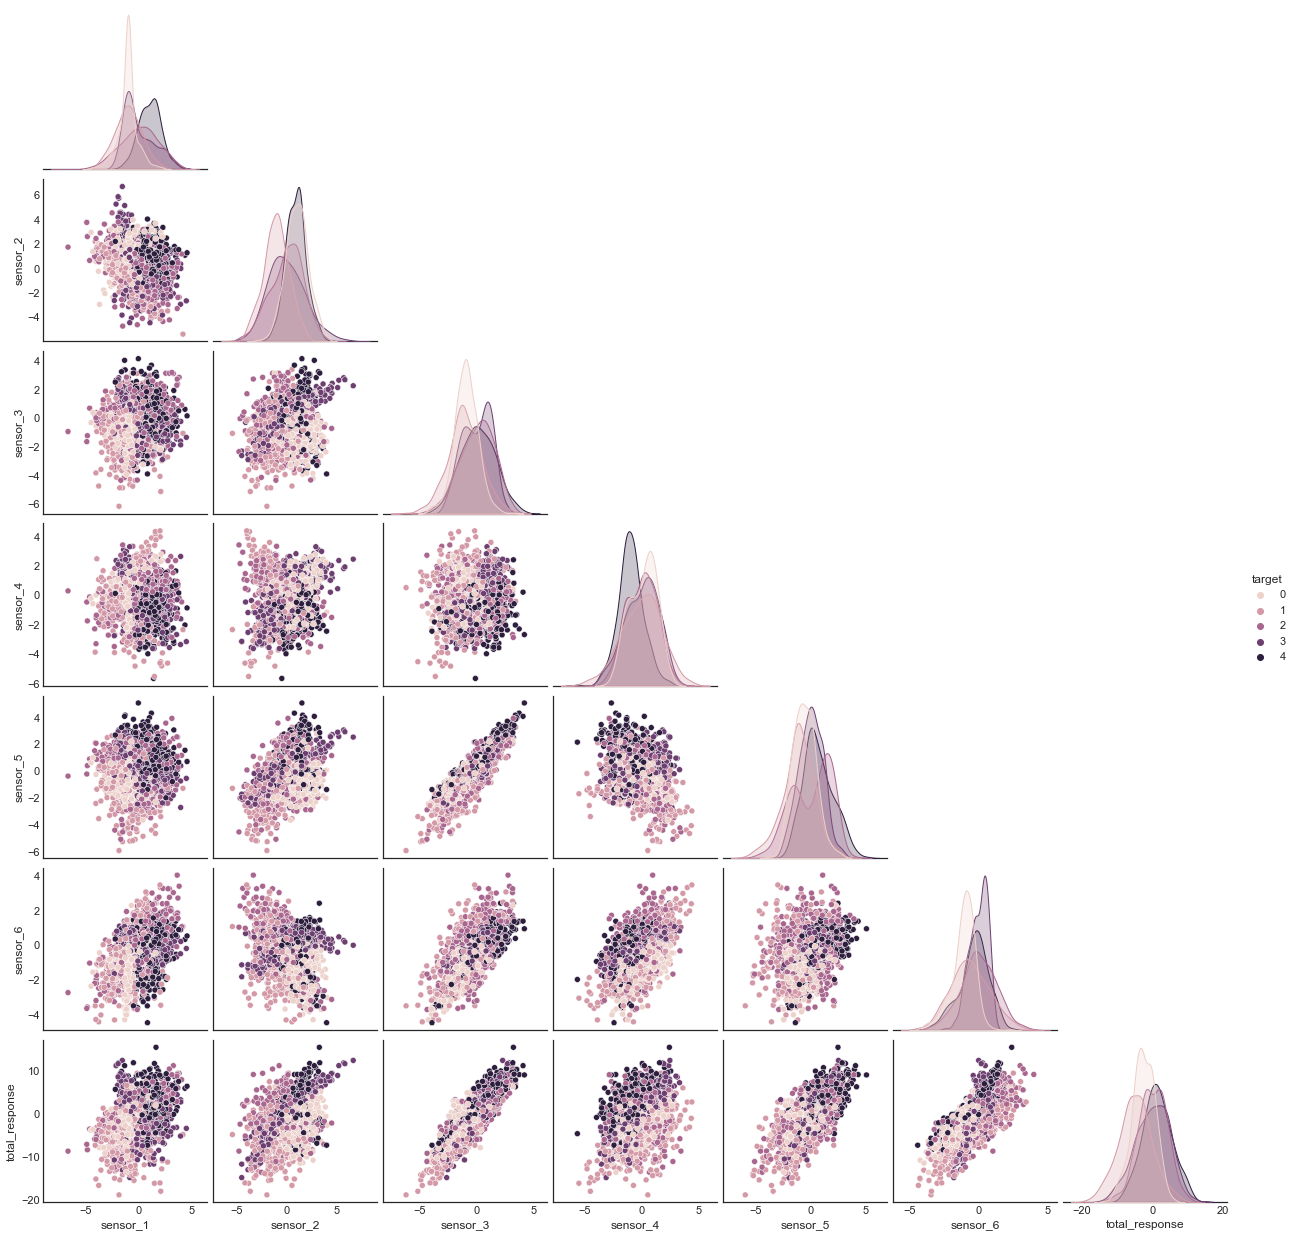

In [13]:
space_X_train_extra= space_X_train.copy()
space_X_train_extra['total_response']=space_X_train['sensor_1']+space_X_train['sensor_2']+space_X_train['sensor_3']+space_X_train['sensor_4']+space_X_train['sensor_5']+space_X_train['sensor_6']
sns.pairplot(space_X_train_extra, corner=True, hue='target')

<AxesSubplot:>

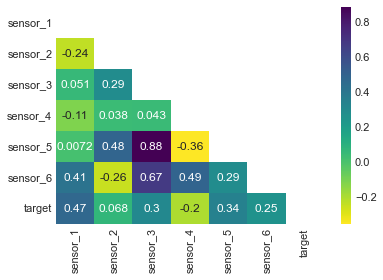

In [14]:
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(space_X_train.corr())

sns.heatmap(space_X_train.corr(), annot=True, cmap='viridis_r', mask=matrix)


From the previous graph it can be concluded that:
* Each class has a gaussian type distribution.
* The different labels form clusters for certain sensors.

There is no need to clean or engineer the Data set.

In [15]:
space_X_train.columns

Index(['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6',
       'target'],
      dtype='object')

In [17]:

x = space_X_train.drop('target',axis=1).values #returns a numpy array
numerical_cols=['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6']

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
space_X_train_min_max_scaled = pd.DataFrame(x_scaled)

scaler = preprocessing.RobustScaler()
space_X_train_robust = scaler.fit_transform(x)
space_X_train_robust = pd.DataFrame(space_X_train_robust, columns =numerical_cols)

scaler = preprocessing.StandardScaler()
space_X_train_standard = scaler.fit_transform(x)
space_X_train_standard = pd.DataFrame(space_X_train_standard, columns =numerical_cols)


In [18]:
space_X_train_min_max_scaled ['target'] = space_X_train['target']
space_X_train_robust ['target'] = space_X_train['target']
space_X_train_standard ['target'] = space_X_train['target']


In [19]:
#space_X_train_scaled['target'] = space_X_train['target']

# Model screening

With Pycaret we test the dataframe with several models to check its performance with :

In [27]:
setup(space_X_train,
          target='target'
    )
best_model=compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7773,0.9442,0.7784,0.7838,0.7774,0.7215,0.7230,0.6740
lightgbm,Light Gradient Boosting Machine,0.7706,0.9437,0.7718,0.7761,0.7704,0.7131,0.7145,0.6430
et,Extra Trees Classifier,0.7651,0.9438,0.7662,0.7711,0.7649,0.7062,0.7077,0.6950
gbc,Gradient Boosting Classifier,0.7447,0.9379,0.7456,0.7509,0.7448,0.6808,0.6821,1.5530
knn,K Neighbors Classifier,0.7433,0.9278,0.7439,0.7500,0.7424,0.6790,0.6809,0.1450
dt,Decision Tree Classifier,0.6698,0.7933,0.6709,0.6749,0.6694,0.5871,0.5884,0.0300
nb,Naive Bayes,0.5677,0.8420,0.5689,0.5718,0.5532,0.4593,0.4653,0.0380
qda,Quadratic Discriminant Analysis,0.5582,0.8542,0.5550,0.6092,0.5561,0.4463,0.4563,0.0300
lr,Logistic Regression,0.5453,0.7955,0.5496,0.5207,0.5205,0.4320,0.4377,2.1240
lda,Linear Discriminant Analysis,0.5385,0.7913,0.5426,0.5149,0.5134,0.4235,0.4294,0.0290


In [29]:
print(best_model)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=853, verbose=0,
                       warm_start=False)


In [ ]:
#space_X_train_scaled['target'] = space_X_train['target']

Let's try with the data modified with scalers: MinMaxScaler, RobustScaler, 

In [32]:
setup(space_X_train_min_max_scaled,
          target='target', 
    )
best_model=compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7659,0.9457,0.7668,0.7697,0.7657,0.7073,0.7082,0.6150
et,Extra Trees Classifier,0.7624,0.9464,0.7631,0.7668,0.7624,0.7030,0.7040,0.5740
lightgbm,Light Gradient Boosting Machine,0.7597,0.9438,0.7600,0.7632,0.7599,0.6996,0.7003,0.5390
knn,K Neighbors Classifier,0.7386,0.9236,0.7386,0.7429,0.7372,0.6731,0.6746,0.1200
gbc,Gradient Boosting Classifier,0.7386,0.9396,0.7395,0.7411,0.7384,0.6733,0.6739,1.3640
dt,Decision Tree Classifier,0.6842,0.8024,0.6850,0.6901,0.6837,0.6051,0.6066,0.0280
qda,Quadratic Discriminant Analysis,0.6412,0.9034,0.6407,0.6665,0.6389,0.5513,0.5578,0.0270
nb,Naive Bayes,0.5569,0.8377,0.5590,0.5584,0.5436,0.4462,0.4513,0.0450
ada,Ada Boost Classifier,0.5398,0.8004,0.5417,0.5272,0.5241,0.4249,0.4289,0.1740
lda,Linear Discriminant Analysis,0.5194,0.7927,0.5193,0.4964,0.4859,0.3989,0.4068,0.0290


In [33]:
print(best_model)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=7610, verbose=0,
                       warm_start=False)


In [34]:
setup(space_X_train_standard,
          target='target'
    )
best_model=compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7434,0.9401,0.7425,0.7454,0.7415,0.6788,0.6802,0.4790
rf,Random Forest Classifier,0.7427,0.9399,0.7418,0.7419,0.7401,0.6780,0.6790,0.6330
lightgbm,Light Gradient Boosting Machine,0.7358,0.9368,0.7352,0.7361,0.7324,0.6694,0.6711,0.5750
knn,K Neighbors Classifier,0.7195,0.9206,0.7178,0.7224,0.7172,0.6489,0.6505,0.1540
gbc,Gradient Boosting Classifier,0.7195,0.9314,0.7178,0.7194,0.7169,0.6490,0.6502,1.8160
dt,Decision Tree Classifier,0.6692,0.7929,0.6680,0.6744,0.6681,0.5859,0.5874,0.0330
qda,Quadratic Discriminant Analysis,0.5875,0.8607,0.5814,0.6118,0.5769,0.4821,0.4916,0.0290
ada,Ada Boost Classifier,0.5602,0.8045,0.5627,0.5498,0.5460,0.4500,0.4537,0.3220
nb,Naive Bayes,0.5541,0.8297,0.5509,0.5524,0.5380,0.4409,0.4464,0.0370
lr,Logistic Regression,0.5228,0.7806,0.5221,0.4991,0.4898,0.4021,0.4098,0.0650


In [35]:
print(best_model)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=3033, verbose=0,
                     warm_start=False)


In [36]:
setup(space_X_train_robust,
          target='target'
    )
best_model=compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7665,0.9459,0.7673,0.7708,0.7657,0.7081,0.7096,0.5650
rf,Random Forest Classifier,0.7529,0.9431,0.7539,0.7575,0.7513,0.6910,0.6928,0.8840
lightgbm,Light Gradient Boosting Machine,0.7441,0.9425,0.7449,0.7495,0.7434,0.6799,0.6815,0.5140
knn,K Neighbors Classifier,0.7434,0.9305,0.7434,0.7472,0.7411,0.6790,0.6808,0.1440
gbc,Gradient Boosting Classifier,0.7305,0.9373,0.7312,0.7345,0.7281,0.6629,0.6648,1.3780
dt,Decision Tree Classifier,0.6671,0.7917,0.6679,0.6724,0.6660,0.5837,0.5853,0.0290
qda,Quadratic Discriminant Analysis,0.5909,0.8652,0.5884,0.6187,0.5916,0.4880,0.4938,0.0280
nb,Naive Bayes,0.5725,0.8420,0.5733,0.5733,0.5594,0.4652,0.4702,0.0400
lr,Logistic Regression,0.5316,0.7912,0.5322,0.5068,0.5044,0.4143,0.4206,0.0560
lda,Linear Discriminant Analysis,0.5221,0.7873,0.5226,0.5032,0.4955,0.4024,0.4089,0.0280


In [37]:
print(best_model)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=1515, verbose=0,
                     warm_start=False)


In [38]:
setup(space_X_train_extra2,
          target='target'
    )
best_model=compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7583,0.9416,0.7593,0.7632,0.7579,0.6979,0.6991,0.6680
gbc,Gradient Boosting Classifier,0.7515,0.9398,0.7526,0.7558,0.7510,0.6894,0.6906,1.7020
et,Extra Trees Classifier,0.7515,0.9437,0.7525,0.7568,0.7514,0.6893,0.6905,0.5540
lightgbm,Light Gradient Boosting Machine,0.7468,0.9394,0.7479,0.7518,0.7457,0.6834,0.6849,0.6350
knn,K Neighbors Classifier,0.7461,0.9200,0.7461,0.7530,0.7450,0.6824,0.6845,0.1260
dt,Decision Tree Classifier,0.6480,0.7798,0.6489,0.6507,0.6473,0.5599,0.5608,0.0290
nb,Naive Bayes,0.5691,0.8253,0.5711,0.5629,0.5495,0.4614,0.4674,0.0320
ada,Ada Boost Classifier,0.5391,0.7928,0.5450,0.5238,0.5151,0.4248,0.4318,0.3140
lr,Logistic Regression,0.5242,0.7824,0.5288,0.4856,0.4879,0.4056,0.4136,0.0580
lda,Linear Discriminant Analysis,0.5160,0.7775,0.5204,0.4943,0.4839,0.3954,0.4031,0.0300


## Random Forest Hyperparameters tunning with Optuna

In [39]:
def scoring_f1(y_test,X_test,method): #generation of f1 macro
    f1score=f1_score(y_test,
                     method.predict(X_test),
                     average= 'macro'
)        
    return f1score  

In [40]:
import optuna

In [41]:
X=space_X_train.copy()
y=X.target
X.drop('target',axis=1, inplace=True)

In [ ]:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=853, verbose=0,
                       warm_start=False)

In [61]:
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,stratify=y)
    
    bootstrap = trial.suggest_categorical('bootstrap',['True','False'])
    max_depth = trial.suggest_int('max_depth', 1, 100000)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt','log2'])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 100000)
    n_estimators =  trial.suggest_int('n_estimators', 30, 1000)
    n_jobs =  trial.suggest_int('n_jobs', 2, 20)
    
    rf_cl = RandomForestClassifier(bootstrap = bootstrap, 
                                   max_depth = max_depth, 
                                   max_features = max_features,
                                   max_leaf_nodes = max_leaf_nodes,
                                   n_estimators = n_estimators,
                                   n_jobs = n_jobs,
                                   criterion='gini',
                                   random_state=853
                                  )
    
    rf_cl.fit(X_train, y_train)
    y_pred = rf_cl.predict(X_test)
    
    score = cross_val_score(rf_cl, X_test, y_test, cv=5, scoring="f1_macro")
    f1_mean = score.mean()

    return f1_mean


In [62]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2022-06-22 20:52:50,842] A new study created in memory with name: no-name-60e72cd7-99fb-4eba-98c6-049b63dc059c
[I 2022-06-22 20:53:21,057] Trial 0 finished with value: 0.7006576486614289 and parameters: {'bootstrap': 'True', 'max_depth': 14886, 'max_features': 'auto', 'max_leaf_nodes': 85460, 'n_estimators': 341, 'n_jobs': 9}. Best is trial 0 with value: 0.7006576486614289.
[I 2022-06-22 20:54:02,198] Trial 1 finished with value: 0.6990566227300867 and parameters: {'bootstrap': 'True', 'max_depth': 59220, 'max_features': 'log2', 'max_leaf_nodes': 83732, 'n_estimators': 625, 'n_jobs': 19}. Best is trial 0 with value: 0.7006576486614289.
[I 2022-06-22 20:54:08,586] Trial 2 finished with value: 0.6960359977273772 and parameters: {'bootstrap': 'False', 'max_depth': 41942, 'max_features': 'sqrt', 'max_leaf_nodes': 67156, 'n_estimators': 102, 'n_jobs': 15}. Best is trial 0 with value: 0.7006576486614289.
[I 2022-06-22 20:54:23,718] Trial 3 finished with value: 0.7027937684575548 and param

In [63]:
import plotly.io as pio #To fix an issue with the renderer of graphs in VSC
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'notebook_connected'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

In [64]:
pio.renderers.default = "notebook_connected"

In [66]:
optuna.visualization.plot_param_importances(study).show()

In [67]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [68]:
study.best_params

{'bootstrap': 'True',
 'max_depth': 21947,
 'max_features': 'log2',
 'max_leaf_nodes': 10448,
 'n_estimators': 522,
 'n_jobs': 11}

In [69]:
# fix the less relevant parameter to continue the optimization
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    
    max_depth = trial.suggest_int('max_depth', 1, 10000)   
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 10000)
    n_estimators =  trial.suggest_int('n_estimators', 30, 1000)
    n_jobs =  trial.suggest_int('n_jobs', 2, 20)
    
    rf_cl = RandomForestClassifier(bootstrap = 'False', 
                                   max_depth = max_depth, 
                                   max_features = 'auto',
                                   max_leaf_nodes = max_leaf_nodes,
                                   n_estimators = n_estimators,
                                   n_jobs = n_jobs,
                                   criterion='gini',
                                   random_state=853
                                  )
    
    rf_cl.fit(X_train, y_train)
    y_pred = rf_cl.predict(X_test)
    
    score = cross_val_score(rf_cl, X_test, y_test, cv=5, scoring="f1_macro")
    f1_mean = score.mean()

    return f1_mean


study.optimize(objective, n_trials=20)

[I 2022-06-22 21:01:14,013] Trial 20 finished with value: 0.7122480076414357 and parameters: {'max_depth': 9964, 'max_leaf_nodes': 9359, 'n_estimators': 819, 'n_jobs': 3}. Best is trial 20 with value: 0.7122480076414357.
[I 2022-06-22 21:01:35,803] Trial 21 finished with value: 0.7100951202679731 and parameters: {'max_depth': 3680, 'max_leaf_nodes': 9960, 'n_estimators': 772, 'n_jobs': 6}. Best is trial 20 with value: 0.7122480076414357.
[I 2022-06-22 21:02:01,102] Trial 22 finished with value: 0.7084124224814149 and parameters: {'max_depth': 4082, 'max_leaf_nodes': 9842, 'n_estimators': 873, 'n_jobs': 2}. Best is trial 20 with value: 0.7122480076414357.
[I 2022-06-22 21:02:22,544] Trial 23 finished with value: 0.7081111280473973 and parameters: {'max_depth': 3940, 'max_leaf_nodes': 9841, 'n_estimators': 905, 'n_jobs': 2}. Best is trial 20 with value: 0.7122480076414357.
[I 2022-06-22 21:02:51,531] Trial 24 finished with value: 0.712333922126083 and parameters: {'max_depth': 3905, 'max

In [71]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [72]:
optuna.visualization.plot_param_importances(study).show()

In [55]:
study.best_params

{'max_depth': 5517, 'max_leaf_nodes': 9597, 'n_estimators': 697, 'n_jobs': 20}

In [73]:
# fix the less relevant parameter to continue the optimization
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    
    max_depth = trial.suggest_int('max_depth', 1, 10000)   
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 4000, 20000)
    n_estimators =  trial.suggest_int('n_estimators', 100, 2000)
    n_jobs =  trial.suggest_int('n_jobs', 2, 6)
    
    rf_cl = RandomForestClassifier(bootstrap = 'False', 
                                   max_depth = max_depth, 
                                   max_features = 'auto',
                                   max_leaf_nodes = max_leaf_nodes,
                                   n_estimators = n_estimators,
                                   n_jobs = n_jobs,
                                   criterion='gini',
                                   random_state=853
                                  )
    
    rf_cl.fit(X_train, y_train)
    y_pred = rf_cl.predict(X_test)
    
    score = cross_val_score(rf_cl, X_test, y_test, cv=5, scoring="f1_macro")
    f1_mean = score.mean()

    return f1_mean


study.optimize(objective, n_trials=20)

[I 2022-06-22 21:11:23,132] Trial 40 finished with value: 0.7074064556519206 and parameters: {'max_depth': 4029, 'max_leaf_nodes': 9680, 'n_estimators': 1186, 'n_jobs': 3}. Best is trial 25 with value: 0.7143263560792905.
[I 2022-06-22 21:11:56,421] Trial 41 finished with value: 0.7181364961274778 and parameters: {'max_depth': 3954, 'max_leaf_nodes': 9634, 'n_estimators': 1652, 'n_jobs': 3}. Best is trial 41 with value: 0.7181364961274778.
[I 2022-06-22 21:12:30,275] Trial 42 finished with value: 0.7158193735337595 and parameters: {'max_depth': 3776, 'max_leaf_nodes': 9521, 'n_estimators': 1601, 'n_jobs': 3}. Best is trial 41 with value: 0.7181364961274778.
[I 2022-06-22 21:13:11,510] Trial 43 finished with value: 0.7165170441222501 and parameters: {'max_depth': 3866, 'max_leaf_nodes': 9737, 'n_estimators': 1731, 'n_jobs': 3}. Best is trial 41 with value: 0.7181364961274778.
[I 2022-06-22 21:13:47,311] Trial 44 finished with value: 0.7165170441222501 and parameters: {'max_depth': 3887,

In [74]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [75]:
optuna.visualization.plot_param_importances(study).show()

In [76]:
study.best_params

{'max_depth': 3954, 'max_leaf_nodes': 9634, 'n_estimators': 1652, 'n_jobs': 3}

In [88]:
# fix the less relevant parameter to continue the optimization
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    
    max_depth = trial.suggest_int('max_depth', 1000, 5000)   
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 4000, 10000)
    n_estimators =  trial.suggest_int('n_estimators', 200, 800)
    n_jobs =  trial.suggest_int('n_jobs', 2, 6)
    
    rf_cl = RandomForestClassifier(bootstrap = 'False', 
                                   max_depth = max_depth, 
                                   max_features = 'auto',
                                   max_leaf_nodes = max_leaf_nodes,
                                   n_estimators = n_estimators,
                                   n_jobs = n_jobs,
                                   criterion='gini',
                                   random_state=853
                                  )
    
    rf_cl.fit(X_train, y_train)
    y_pred = rf_cl.predict(X_test)
    
    score = cross_val_score(rf_cl, X_test, y_test, cv=5, scoring="f1_macro")
    f1_mean = score.mean()

    return f1_mean


study.optimize(objective, n_trials=20)

[I 2022-06-22 21:43:37,439] Trial 87 finished with value: 0.7175489913138143 and parameters: {'max_depth': 3796, 'max_leaf_nodes': 9507, 'n_estimators': 300, 'n_jobs': 2}. Best is trial 79 with value: 0.7196057856124378.
[I 2022-06-22 21:43:46,164] Trial 88 finished with value: 0.7147255742713291 and parameters: {'max_depth': 3820, 'max_leaf_nodes': 9512, 'n_estimators': 284, 'n_jobs': 2}. Best is trial 79 with value: 0.7196057856124378.
[I 2022-06-22 21:43:53,907] Trial 89 finished with value: 0.7178178511107678 and parameters: {'max_depth': 3861, 'max_leaf_nodes': 9519, 'n_estimators': 271, 'n_jobs': 2}. Best is trial 79 with value: 0.7196057856124378.
[I 2022-06-22 21:44:02,785] Trial 90 finished with value: 0.7157421601978676 and parameters: {'max_depth': 3774, 'max_leaf_nodes': 9500, 'n_estimators': 270, 'n_jobs': 2}. Best is trial 79 with value: 0.7196057856124378.
[I 2022-06-22 21:44:09,648] Trial 91 finished with value: 0.7133318266746401 and parameters: {'max_depth': 3710, 'ma

In [96]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [90]:
optuna.visualization.plot_param_importances(study).show()

In [91]:
study.optimize(objective, n_trials=10)

[I 2022-06-22 21:48:46,336] Trial 107 finished with value: 0.7175300946995377 and parameters: {'max_depth': 4033, 'max_leaf_nodes': 9300, 'n_estimators': 277, 'n_jobs': 3}. Best is trial 97 with value: 0.7209692523524147.
[I 2022-06-22 21:48:54,585] Trial 108 finished with value: 0.7186777660609284 and parameters: {'max_depth': 3964, 'max_leaf_nodes': 9396, 'n_estimators': 282, 'n_jobs': 3}. Best is trial 97 with value: 0.7209692523524147.
[I 2022-06-22 21:49:01,878] Trial 109 finished with value: 0.7186777660609284 and parameters: {'max_depth': 4017, 'max_leaf_nodes': 9359, 'n_estimators': 282, 'n_jobs': 3}. Best is trial 97 with value: 0.7209692523524147.
[I 2022-06-22 21:49:10,188] Trial 110 finished with value: 0.7147255742713291 and parameters: {'max_depth': 3983, 'max_leaf_nodes': 9388, 'n_estimators': 284, 'n_jobs': 3}. Best is trial 97 with value: 0.7209692523524147.
[I 2022-06-22 21:49:17,794] Trial 111 finished with value: 0.7209692523524147 and parameters: {'max_depth': 4010

In [92]:
study.optimize(objective, n_trials=10)


[I 2022-06-22 21:50:46,089] Trial 117 finished with value: 0.7209692523524147 and parameters: {'max_depth': 4032, 'max_leaf_nodes': 9445, 'n_estimators': 281, 'n_jobs': 3}. Best is trial 97 with value: 0.7209692523524147.
[I 2022-06-22 21:50:53,034] Trial 118 finished with value: 0.7175300946995377 and parameters: {'max_depth': 4014, 'max_leaf_nodes': 9424, 'n_estimators': 276, 'n_jobs': 3}. Best is trial 97 with value: 0.7209692523524147.
[I 2022-06-22 21:51:01,442] Trial 119 finished with value: 0.7192498090050643 and parameters: {'max_depth': 4020, 'max_leaf_nodes': 9318, 'n_estimators': 280, 'n_jobs': 3}. Best is trial 97 with value: 0.7209692523524147.
[I 2022-06-22 21:51:08,604] Trial 120 finished with value: 0.7152246576635225 and parameters: {'max_depth': 4040, 'max_leaf_nodes': 9262, 'n_estimators': 292, 'n_jobs': 3}. Best is trial 97 with value: 0.7209692523524147.
[I 2022-06-22 21:51:16,973] Trial 121 finished with value: 0.717389587355369 and parameters: {'max_depth': 4017,

In [95]:
study.optimize(objective, n_trials=10)


[I 2022-06-22 21:54:30,871] Trial 138 finished with value: 0.7196780727604631 and parameters: {'max_depth': 4084, 'max_leaf_nodes': 9242, 'n_estimators': 266, 'n_jobs': 4}. Best is trial 97 with value: 0.7209692523524147.
[I 2022-06-22 21:54:37,726] Trial 139 finished with value: 0.717602381847563 and parameters: {'max_depth': 4119, 'max_leaf_nodes': 9240, 'n_estimators': 268, 'n_jobs': 4}. Best is trial 97 with value: 0.7209692523524147.
[I 2022-06-22 21:54:46,338] Trial 140 finished with value: 0.7176169363377707 and parameters: {'max_depth': 4061, 'max_leaf_nodes': 9318, 'n_estimators': 264, 'n_jobs': 4}. Best is trial 97 with value: 0.7209692523524147.
[I 2022-06-22 21:54:53,524] Trial 141 finished with value: 0.7196780727604631 and parameters: {'max_depth': 4045, 'max_leaf_nodes': 9321, 'n_estimators': 269, 'n_jobs': 4}. Best is trial 97 with value: 0.7209692523524147.
[I 2022-06-22 21:55:01,519] Trial 142 finished with value: 0.7157421601978676 and parameters: {'max_depth': 4101,

In [87]:
study.best_params

{'max_depth': 3770, 'max_leaf_nodes': 9507, 'n_estimators': 274, 'n_jobs': 2}

In [84]:

study.optimize(objective, n_trials=20)

[W 2022-06-22 21:39:08,487] Trial 84 failed because of the following error: ValueError('CategoricalDistribution does not support dynamic value space.')
Traceback (most recent call last):
  File "c:\Users\march\anaconda3\envs\EDA_i_ML_37\lib\site-packages\optuna\study\_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\march\AppData\Local\Temp\ipykernel_26964\1792266268.py", line 6, in objective
    bootstrap = trial.suggest_categorical('bootstrap',['False'])
  File "c:\Users\march\anaconda3\envs\EDA_i_ML_37\lib\site-packages\optuna\trial\_trial.py", line 505, in suggest_categorical
    return self._suggest(name, CategoricalDistribution(choices=choices))
  File "c:\Users\march\anaconda3\envs\EDA_i_ML_37\lib\site-packages\optuna\trial\_trial.py", line 724, in _suggest
    storage.set_trial_param(trial_id, name, param_value_in_internal_repr, distribution)
  File "c:\Users\march\anaconda3\envs\EDA_i_ML_37\lib\site-packages\optuna\storages\_in_memory.py

ValueError: CategoricalDistribution does not support dynamic value space.

In [86]:
# fix the less relevant parameter to continue the optimization
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
  
    n_jobs =  trial.suggest_int('n_jobs', 2, 6)
    bootstrap = trial.suggest_categorical('bootstrap',['False'])
    max_features = trial.suggest_categorical('max_features', ['auto'])
        
    rf_cl = RandomForestClassifier(bootstrap = 'False', 
                                   max_depth = 2511, 
                                   max_features =  'auto',
                                   max_leaf_nodes = 9249,
                                   n_estimators = 610,
                                   n_jobs = n_jobs,
                                   criterion='gini',
                                   random_state=853
                                  )
    
    rf_cl.fit(X_train, y_train)
    y_pred = rf_cl.predict(X_test)
    
    score = cross_val_score(rf_cl, X_test, y_test, cv=5, scoring="f1_macro")
    f1_mean = score.mean()

    return f1_mean


study.optimize(objective, n_trials=20)

[W 2022-06-22 21:42:07,060] Trial 86 failed because of the following error: ValueError('CategoricalDistribution does not support dynamic value space.')
Traceback (most recent call last):
  File "c:\Users\march\anaconda3\envs\EDA_i_ML_37\lib\site-packages\optuna\study\_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\march\AppData\Local\Temp\ipykernel_26964\1770833401.py", line 6, in objective
    bootstrap = trial.suggest_categorical('bootstrap',['False'])
  File "c:\Users\march\anaconda3\envs\EDA_i_ML_37\lib\site-packages\optuna\trial\_trial.py", line 505, in suggest_categorical
    return self._suggest(name, CategoricalDistribution(choices=choices))
  File "c:\Users\march\anaconda3\envs\EDA_i_ML_37\lib\site-packages\optuna\trial\_trial.py", line 724, in _suggest
    storage.set_trial_param(trial_id, name, param_value_in_internal_repr, distribution)
  File "c:\Users\march\anaconda3\envs\EDA_i_ML_37\lib\site-packages\optuna\storages\_in_memory.py

ValueError: CategoricalDistribution does not support dynamic value space.

In [110]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [120]:
study.best_params

{'max_depth': 2511, 'max_leaf_nodes': 9249, 'n_estimators': 610, 'n_jobs': 2}

## test_X prediction

To take advantage of all the dataset, the model with the best hyperparameters is fitted with the whole train data:

In [121]:
best_final_model = RandomForestClassifier(bootstrap = 'False', 
                                   max_depth = 2511, 
                                   max_features =  'auto',
                                   max_leaf_nodes = 9249,
                                   n_estimators = 610,
                                   n_jobs = 2                       
                                   )

In [125]:
X_final=space_X_train.copy()
X_final.drop('target', axis=1,inplace=True)
y_final = space_X_train.target

In [126]:
X_final

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6
0,0.474335,0.881640,-2.050543,-1.251935,-1.035151,-1.934367
1,-1.034675,1.741801,-1.660629,-1.555989,-0.337553,-2.473838
2,-0.563221,-0.688381,-0.318415,-1.845172,0.352366,-0.912928
3,-1.268179,2.770688,1.054193,2.830389,0.395093,0.677715
4,-1.216380,-0.391267,-2.898931,-0.913074,-2.171857,-2.367490
...,...,...,...,...,...,...
2095,-0.947002,0.174969,-0.180249,0.118236,-0.143420,-0.359509
2096,-1.224148,0.029956,0.536684,0.888406,0.119460,0.378946
2097,-0.847593,1.538574,0.962409,1.966467,0.379934,0.737907
2098,1.472437,1.187695,1.015766,-1.103522,1.586722,0.182569


In [127]:
best_final_model.fit(X_final,y_final)

RandomForestClassifier(bootstrap='False', ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2511, max_features='auto',
                       max_leaf_nodes=9249, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=610, n_jobs=2,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

Charge test_X dataset to be predicted. We check its statistically ressemblance to the training data set.:

In [117]:
test_x=pd.read_csv(r'C:\Users\march\000 Treball Ju`yter 000\Hackathons\Hackathon_Talent_Squad\initial_docs\space_X_test.csv',index_col=None)

test_x.isnull().sum()

Unnamed: 0    0
sensor_1      0
sensor_2      0
sensor_3      0
sensor_4      0
sensor_5      0
sensor_6      0
dtype: int64

In [118]:
test_x.shape

(900, 7)

In [119]:
test_x.drop('Unnamed: 0', axis=1, inplace=True)
test_x.describe()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,-0.170339,0.135481,-0.447035,-0.201708,-0.263349,-0.445490
std,1.485402,1.547202,1.394437,1.487102,1.450823,1.215000
min,-5.084203,-4.292548,-4.628992,-6.732089,-5.196997,-4.823971
25%,-1.098759,-0.934171,-1.460497,-1.163163,-1.182667,-1.152891
50%,-0.386297,0.341427,-0.464239,-0.177710,-0.233699,-0.410182
75%,0.881170,1.246296,0.626893,0.870332,0.679282,0.399597
max,4.636012,4.612113,3.299946,5.996929,3.917118,5.357953


In [128]:
x_test_pred = best_final_model.predict(test_x)
x_test_pred

array([1, 3, 2, 0, 3, 2, 4, 0, 2, 3, 1, 4, 1, 1, 4, 4, 4, 3, 2, 0, 1, 2,
       4, 0, 0, 3, 0, 2, 2, 4, 2, 2, 4, 3, 3, 1, 0, 4, 3, 0, 4, 2, 3, 2,
       2, 0, 0, 1, 2, 4, 4, 0, 2, 0, 4, 4, 1, 3, 3, 0, 3, 0, 3, 0, 4, 1,
       1, 0, 2, 3, 0, 1, 4, 0, 4, 0, 0, 1, 2, 3, 4, 3, 1, 3, 1, 1, 2, 3,
       1, 2, 2, 4, 1, 1, 0, 1, 4, 2, 0, 4, 0, 0, 0, 4, 2, 4, 4, 4, 1, 2,
       4, 1, 3, 3, 3, 2, 1, 4, 2, 2, 0, 4, 4, 3, 1, 2, 4, 1, 3, 2, 2, 1,
       4, 0, 0, 2, 3, 0, 0, 4, 0, 4, 3, 2, 1, 3, 4, 3, 4, 4, 1, 2, 1, 2,
       0, 4, 2, 4, 4, 2, 0, 2, 3, 1, 1, 4, 0, 3, 2, 0, 1, 2, 4, 4, 1, 2,
       3, 0, 3, 4, 2, 1, 0, 2, 2, 2, 0, 3, 4, 1, 1, 1, 2, 4, 0, 0, 4, 4,
       1, 2, 0, 2, 4, 3, 2, 2, 3, 1, 1, 3, 0, 0, 2, 1, 1, 3, 4, 2, 2, 1,
       2, 2, 2, 0, 3, 2, 0, 2, 2, 3, 0, 2, 4, 3, 2, 4, 0, 3, 3, 3, 0, 4,
       3, 0, 2, 0, 2, 1, 2, 0, 2, 3, 1, 3, 1, 1, 0, 3, 2, 4, 2, 1, 0, 2,
       2, 4, 2, 4, 1, 2, 1, 4, 2, 0, 3, 0, 1, 4, 2, 4, 1, 1, 2, 1, 1, 4,
       0, 0, 2, 2, 3, 1, 0, 2, 0, 0, 4, 4, 1, 4, 0,

In [136]:
predictions_df=pd.DataFrame(x_test_pred,columns=['final_status'])
predictions_df

,final_status
0,1
1,3
2,2
3,0
4,3
...,...
895,3
896,4
897,0
898,3


In [137]:

predictions_df.predictions_df.to_csv(r'C:\Users\march\000 Treball Ju`yter 000\Hackathons\Hackathon_Talent_Squad\predictions.csv',index=False)

In [140]:
pip list > requirements.txt

Note: you may need to restart the kernel to use updated packages.
